In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [2]:
!kaggle datasets download -d shruti009000/fruit-and-vegetable-recognition

Dataset URL: https://www.kaggle.com/datasets/shruti009000/fruit-and-vegetable-recognition
License(s): CC0-1.0
100% 1.88G/1.89G [00:24<00:00, 70.1MB/s]
100% 1.89G/1.89G [00:24<00:00, 83.7MB/s]


In [3]:
import zipfile
zip_r = zipfile.ZipFile('/content/fruit-and-vegetable-recognition.zip','r')
zip_r.extractall('/content')
zip_r.close()

In [4]:
calorie_dict = {
    'apple': 52,
    'banana': 89,
    'carrot': 41,
    'orange': 47,
    'broccoli': 34,
    'tomato': 18,
    'strawberry': 32,
    'grapes': 69,
    'watermelon': 30,
    'blueberry': 57,
    'mango': 60,
    'pear': 57,
    'pineapple': 50,
    'cucumber': 16,
    'lettuce': 15,
    'spinach': 23,
    'potato': 77,
    'onion': 40,
    'garlic': 149,
    'pepper': 40,
    'kiwi': 61,
    'avocado': 160,
    'cherry': 50,
    'peach': 39,
    'plum': 46,
    'pomegranate': 83,
    'cabbage': 25,
    'cauliflower': 25,
    'eggplant': 25,
    'celery': 16,
    'radish': 16,
    'beetroot': 43,
    'pumpkin': 26,
    'zucchini': 17,
    'Capsicum' : 20 ,
    'Corn': 86 ,
    'Guava': 68 ,
    'Jalapeño': 29,
    'Lemon': 29 ,
    'Turnip': 28 ,
    'Soybeans': 173,
    'Peas': 81,
    'Sweet corn': 86,
    'Sweet potato': 86,
    'Papaya': 43
    # Add more items as needed
}
print(len(calorie_dict))

45


In [35]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
import pandas as pd



In [6]:
img_size = 224
batch_size = 32

In [7]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

In [8]:
train_generator = train_datagen.flow_from_directory(
    '/content/fruit and vegetable database/fruit and vegetable database/train',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

Found 2558 images belonging to 37 classes.


In [9]:
val_generator = train_datagen.flow_from_directory(
    '/content/fruit and vegetable database/fruit and vegetable database/test',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 73 images belonging to 37 classes.


In [10]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

9406464/9406464 [==============================] - 0s 0us/step


In [11]:
x = base_model.output
x = Flatten()(x)
predictions = Dense(37, activation='softmax')(x)  # 3 classes (apple, banana, orange)

model = Model(inputs=base_model.input, outputs=predictions)

In [12]:
# Freeze base layers
for layer in base_model.layers:
    layer.trainable = False

In [13]:
#compile
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [27]:
from tensorflow.keras.models import load_model
import numpy as np
import cv2

In [ ]:
# Train model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


80/80 [==============================] - 197s 2s/step - loss: 1.8533 - accuracy: 0.9159 - val_loss: 0.5007 - val_accuracy: 0.9589
Epoch 2/5
70/80 [=========================>....] - ETA: 23s - loss: 1.7593 - accuracy: 0.9182

In [42]:
# Load the trained model
model = load_model('food_recognition_model.h5')

In [43]:
# Function to predict and estimate calories
def predict_and_estimate(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (img_size, img_size))
    img = np.expand_dims(img, axis=0) / 255.0  # Normalize
    prediction = model.predict(img)
    predicted_class = np.argmax(prediction)
    for class_name, class_idx in train_generator.class_indices.items():
        if class_idx == predicted_class:
            food_type = class_name
            break

    calorie_estimate = calorie_dict.get(food_type, 'Unknown')

    print(f"Detected Food: {food_type}")
    print(f"Estimated Calories per 100g: {calorie_estimate}")


In [44]:
# Example usage
image_path = '/content/testing/testing/eggplant.jpg'
predict_and_estimate(image_path)

1/1 [==============================] - 1s 1s/step
Detected Food: eggplant
Estimated Calories per 100g: 25


In [45]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [46]:
eval_results = model.evaluate(val_generator, steps=val_generator.samples // batch_size)
print(f"Validation Accuracy: {eval_results[1]*100:.2f}%")

2/2 [==============================] - 7s 2s/step - loss: 2.7018 - accuracy: 0.9062
Validation Accuracy: 90.62%


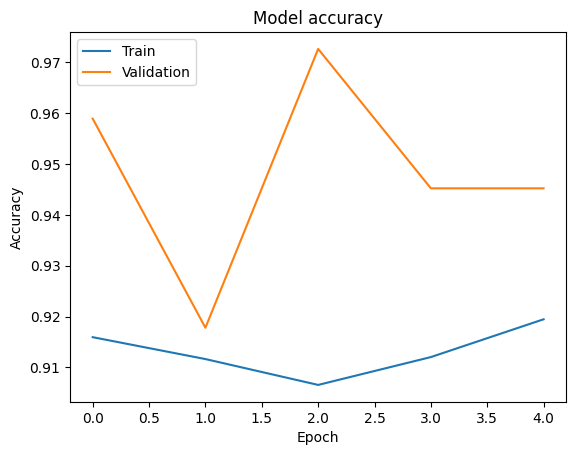

In [47]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


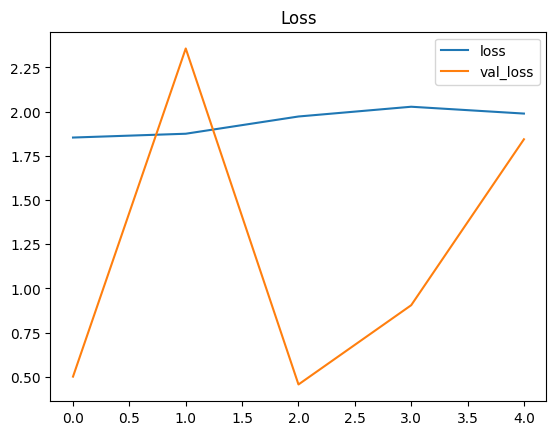

In [48]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [49]:
# Predict labels for the validation set
val_generator.reset()  # Reset generator to start at the beginning
y_pred = model.predict(val_generator, steps=val_generator.samples // batch_size + 1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_generator.classes


3/3 [==============================] - 15s 2s/step


In [50]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
class_names = list(train_generator.class_indices.keys())


<Figure size 800x600 with 0 Axes>

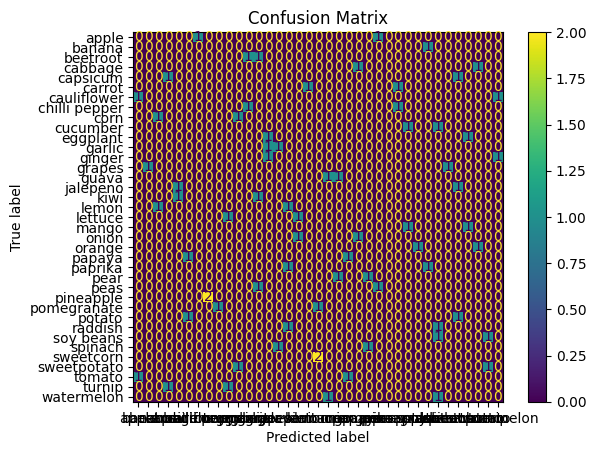

In [51]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm_display = ConfusionMatrixDisplay(cm, display_labels=class_names).plot(cmap='viridis', values_format='d')
plt.title('Confusion Matrix')
plt.show()

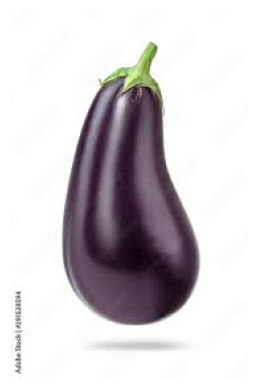

In [53]:
# Display an image from the testing dataset
def display_image(image_path):
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB for Matplotlib display
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.show()

# Example usage
image_path = '/content/testing/testing/eggplant.jpg'
display_image(image_path)